In [1]:
import torch
from torch.autograd import Variable
from torch import nn
import numpy as np
import torch.optim as optim
from data import fig
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

## Data Load

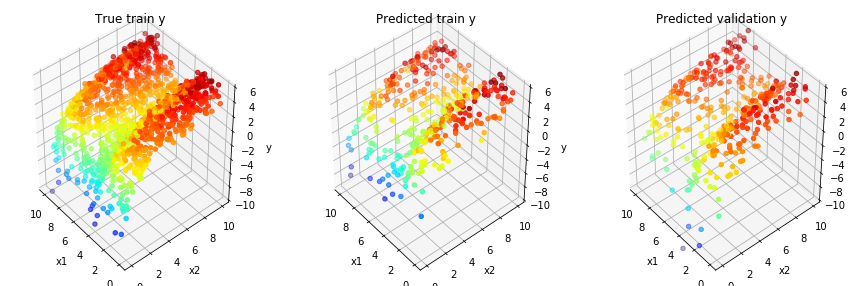

In [2]:
# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_Y = X[:1600, :], y[:1600]
val_X, val_Y = X[1600:2000, :], y[1600:2000]
test_X, test_Y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig.show_3dgraph(train_X, train_Y, val_X, val_Y, test_X, test_Y)

In [3]:
train_x, train_y = torch.Tensor(train_X), torch.Tensor(train_Y).view(len(train_Y),-1)
val_x, val_y = torch.Tensor(val_X), torch.Tensor(val_Y).view(len(val_Y),-1)
test_x, test_y = torch.Tensor(test_X), torch.Tensor(test_Y).view(len(test_Y),-1)

# 모델을 구축하고 학습해보세요.

## Define Model

파이썬 메서드의 첫번째 파라미터명은 관례적으로 self라는 이름을 사용합니다.
호출 시 호출한 객체 자신이 전달되기 때문에 self라는 이름을 사용하게 된 것

간혹 여러 자료들을 보면.. __init__ 메소드를 생성자로 소개하는 경우가 있는데, 그렇지 않습니다. 파이썬에서 클래스를 만들 시 __init__ 메소드만 오버라이딩하여 객체초기화에만 이용합니다. __init__가 self를 받으며 객체의 내부에서 사용할 속성을 초기화 합니다.

https://dojang.io/mod/page/view.php?id=2396

In [6]:
class LinearModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [7]:
class MLPModel(nn.Module):
    def __init__(self): 
        super().__init__()

    
    def forward(self, x):

        return x

In [8]:
# model  = nn.Linear(2, 1, bias=True)
model = LinearModel()
# model = MLPModel()
# print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

## Define Cost Function

In [ ]:
cost_func = nn.MSELoss()

## Define Optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005)

## Training Model

In [ ]:
def train(train_loader, model, cost_func, optimizer, epoch, log_interval=5):
    model.train()
    train_loss = 0
    pred_train = []
    pred_val = []
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data)
        pred_train.extend(output.reshape(-1).tolist())
        cost = cost_func(output, target)
        train_loss += cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
        
    return train_loss, pred_train

## Testing Model

with torch.no_grad(): 범위 안에서는 gradient 계산을 하지 않는다. 메모리를 사용하는 것)을 방지하기 위해, 코드 블럭을 with torch.no_grad(): 로 감쌀 수 있습니다

In [ ]:
def test(x, y, model, cost_func) :
    model.eval()
    test_loss = 0
    prediction = []
    with torch.no_grad():
        output = model(x)
        prediction.extend(output.reshape(-1).tolist())
        test_loss = cost_func(output, y)

    return test_loss, prediction

## Training start

In [ ]:
batch_size = 128

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
epochs = 200
log_interval = 10
list_epoch = []
list_train_loss = []
list_val_loss = []

for epoch in range(0, epochs + 1):
    train_loss, pred_y = train(train_loader, model, 
                            cost_func, optimizer, epoch, log_interval)
    val_loss, pred_val = test(val_x, val_y, model, cost_func)
    
    list_epoch.append(epoch)
    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)

    if epoch % log_interval == 0:
        
        print('Epoch: {}  Train set: Average loss: {:.4f}'.format(epoch, train_loss))
        print('\t  Test set: Average loss: {:.4f}'.format(val_loss))
        
        fig.show_3dgraph(train_X, train_Y, train_X, np.array(pred_y), val_X, np.array(pred_val))

## Test

In [ ]:
test_loss, pred_y = test(test_x, test_y, model, cost_func)
print('\t  Test set: Average loss: {:.4f}'.format(test_loss))
fig.show_2dgragh(test_X, test_Y, pred_y)

## Loss graph

학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 떨어뜨림을 뜻합니다.(overfitting)

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.show()